### Parallel Execution

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class InputState(TypedDict):
    # string_value: str
    string_value: Annotated[str, operator.add]

In [2]:
def append_a(state: InputState) -> Any:
    print(f"append_a: Current string_value='{state['string_value']}'")
    state["string_value"] += "a"
    return state


def append_b(state: InputState) -> Any:
    print(f"append_b: Current string_value='{state['string_value']}'")
    state["string_value"] += "b"
    return state


def append_c(state: InputState) -> Any:
    print(f"append_c: Current string_value='{state['string_value']}'")
    state["string_value"] += "c"
    return state


def combine_strings(state: InputState) -> Any:
    combined_string = state["string_value"]
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state["string_value"] = final_string
    return state

In [3]:
builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)
builder.add_node("append_a_node", append_a)
builder.add_node("append_b_node", append_b)
builder.add_node("append_c_node", append_c)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "append_a_node")
builder.add_edge("start_node", "append_b_node")
builder.add_edge("start_node", "append_c_node")

builder.add_edge("append_a_node", "combine_node")
builder.add_edge("append_b_node", "combine_node")
builder.add_edge("append_c_node", "combine_node")

builder.add_edge("combine_node", END)

graph = builder.compile()

initial_state = {"string_value": ""}

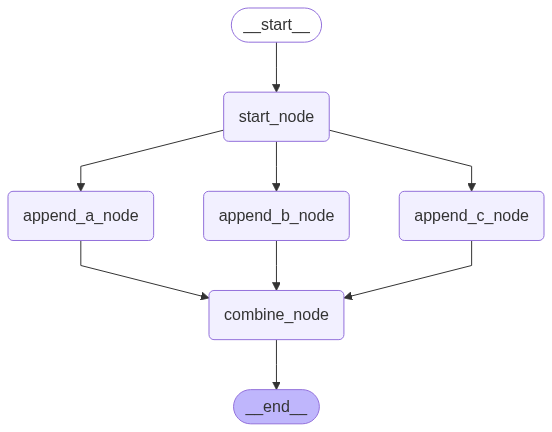

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
result = graph.invoke(initial_state)
print(result)

append_a: Current string_value=''
append_b: Current string_value=''
append_c: Current string_value=''
combine_strings: Combined string_value='abc'
combine_strings: Final string_value='ABC'
{'string_value': 'abcABC'}


### Mapreduce with Send API

In [6]:
import operator
import random
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display


class State(TypedDict):
    string_value: Annotated[str, operator.add]
    letters: List[str]


def generate_letters(_: State) -> Any:
    num_nodes = random.randint(5, 10)
    letters = random.choices(["a", "b", "c", "d", "e"], k=num_nodes)
    print(f"Generated letters: {letters}")
    return {"letters": letters}


def generate_random_nodes(state: State):
    letters = state["letters"]
    print(f"Using letters from state: {letters}")
    return [Send("append_letter", {"letter": letter}) for letter in letters]


def append_letter(state: State) -> Any:
    letter = state["letter"]
    print(f"Appending '{letter}'")
    return {"string_value": letter}


def combine_strings(state: State) -> Any:
    combined_string = state["string_value"]
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    return {"string_value": final_string}


builder = StateGraph(State)
builder.add_node("start_node", lambda state: state)
builder.add_node("generate_letters", generate_letters)
builder.add_node("append_letter", append_letter)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")
builder.add_edge("start_node", "generate_letters")
builder.add_conditional_edges(
    "generate_letters", generate_random_nodes, ["append_letter"]
)
builder.add_edge("append_letter", "combine_node")
builder.add_edge("combine_node", END)

graph = builder.compile()

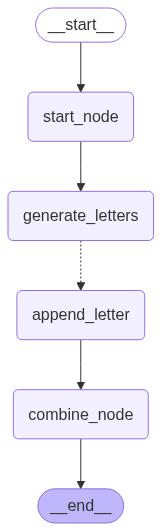

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
initial_state = {"string_value": ""}
result = graph.invoke(initial_state)

print(result)

Generated letters: ['b', 'd', 'e', 'e', 'c', 'a', 'b', 'a']
Using letters from state: ['b', 'd', 'e', 'e', 'c', 'a', 'b', 'a']
Appending 'b'
Appending 'd'
Appending 'e'
Appending 'e'
Appending 'c'
Appending 'a'
Appending 'b'
Appending 'a'
combine_strings: Combined string_value='bdeecaba'
combine_strings: Final string_value='BDEECABA'
{'string_value': 'bdeecabaBDEECABA', 'letters': ['b', 'd', 'e', 'e', 'c', 'a', 'b', 'a']}
